# Experiments GNN

Evaluate **GNN + FlatAdapter**  benchmark power systems: **pandapower test cases 14, 30, 57, and 118-bus** networks, to assess scalability and robustness across system sizes.




# 0) Load Data

In [24]:
import ast, math, json, re
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.utils import coalesce
from torch_geometric.nn import SAGEConv, GraphConv, GATConv, ChebConv, GCNConv
import pandapower.networks as nw
import os
import matplotlib.pyplot as plt


In [2]:
path = 'C:/Users/Usuario/OneDrive - Universidad Adolfo Ibanez/Desktop/GNN/PaperGNNPFFlatAdapter/'

In [ ]:
train14 = pd.read_excel('train_data_final_14_buses.xlsx')
val14 = pd.read_excel('val_data_final_14_buses.xlsx')
test14 = pd.read_excel('test_data_final_14_buses.xlsx')
train30 = pd.read_excel('train_data_final_30_buses.xlsx')
val30 = pd.read_excel('val_data_final_30_buses.xlsx')
test30 = pd.read_excel('test_data_final_30_buses.xlsx')
train118 = pd.read_excel('train_data_final_118_buses.xlsx')
val118 = pd.read_excel('val_data_final_118_buses.xlsx')
test118 = pd.read_excel('test_data_final_118_buses.xlsx')

In [ ]:

DATASETS = {
     14:  {"train": train14,  "val": val14,  "test": test14},
     30:  {"train": train30,  "val": val30,  "test": test30},
    118: {"train": train118, "val": val118, "test": test118},
 }

# 1) Baseline GNN Power Flow

  
The architecture used is based on the following reference:  [https://github.com/Amirtalebi83/GNN-OptimalPowerFlow](https://github.com/Amirtalebi83/GNN-OptimalPowerFlow)


In [17]:
class My_GNN_GNN_NN(nn.Module):
    def __init__(self, node_size, feat_in, feat_size1, feat_size2, hidden_size1, output_size, gnn_type='GraphConv', dropout=0, use_batch_norm=False):
        super(My_GNN_GNN_NN, self).__init__()

        self.use_batch_norm = use_batch_norm
        self.node_size = node_size
        self.feat_size2 = feat_size2

        # GNN Layer Selection
        if gnn_type == 'GCN':
            self.conv1 = GCNConv(feat_in, feat_size1)
            self.conv2 = GCNConv(feat_size1, feat_size2)
        elif gnn_type == 'GraphConv':
            self.conv1 = GraphConv(feat_in, feat_size1)
            self.conv2 = GraphConv(feat_size1, feat_size2)
        elif gnn_type == 'SAGEConv':
            self.conv1 = SAGEConv(feat_in, feat_size1)
            self.conv2 = SAGEConv(feat_size1, feat_size2)
        elif gnn_type == 'GATConv':
            self.conv1 = GATConv(feat_in, feat_size1)
            self.conv2 = GATConv(feat_size1, feat_size2)
        elif gnn_type == 'ChebConv':
            self.conv1 = ChebConv(feat_in, feat_size1, K=2)
            self.conv2 = ChebConv(feat_size1, feat_size2, K=2)
        else:
            raise ValueError("Invalid GNN type. Choose from 'GCN', 'GraphConv', 'SAGEConv', 'GATConv', 'ChebConv'.")

        # Batch Normalization Layers
        if use_batch_norm:
            self.bn1 = nn.BatchNorm1d(feat_size1)
            self.bn2 = nn.BatchNorm1d(feat_size2)

        # Fully Connected Layers
        self.lin1 = nn.Linear(node_size * feat_size2, hidden_size1)
        self.lin2 = nn.Linear(hidden_size1, output_size)

        # Dropout Layer
        self.dropout = nn.Dropout(dropout)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        batch_size = data.num_graphs

        # GNN Layer 1
        x = self.conv1(x, edge_index)
        if self.use_batch_norm:
            x = self.bn1(x)
        x = self.dropout(x)
        x = F.relu(x)

        # GNN Layer 2
        x = self.conv2(x, edge_index)
        if self.use_batch_norm:
            x = self.bn2(x)
        x = self.dropout(x)
        x = F.relu(x)

        # Reshape x for the Fully Connected layer
        x = x.view(batch_size, self.node_size * self.feat_size2)

        # Fully Connected Layers
        x = F.relu(self.lin1(x))
        x = self.lin2(x)

        return x

    def save_weights(self, filename):
        torch.save(self.state_dict(), filename)

    def load_weights(self, filename):
        self.load_state_dict(torch.load(filename))
        self.eval()
        
from operator import is_
def slice_dataset(dataset, percentage):
    data_size = len(dataset)
    return dataset[:int(data_size * percentage / 100)]

def make_dataset(dataset, n_bus):
    x_raw, y_raw = [], []

    for i in range(len(dataset)):
        x_sample, y_sample = [], []
        for n in range(n_bus):
            # Define bus type: Slack (1), PQ (2), PV (3)
            is_pv = 0
            is_pq = 0
            is_slack = 0
            if n == 0:  # Slack bus is always bus 0
                is_slack = 1
            elif dataset[i, 4 * n + 2] == 0:  # Q = 0 indicates PV bus
                is_pv = 1
            else:
                is_pq = 1  # PQ bus

            # Include P, Q, V, delta, and bus type as features
            x_sample.append([
                dataset[i, 4 * n + 1],  # P
                dataset[i, 4 * n + 2],  # Q
               # dataset[i, 4 * n + 3],  # V
               # dataset[i, 4 * n + 4],  # delta
                is_pv,                # Bus type
                is_pq,
                is_slack
            ])

            # Use P and Q as targets
            y_sample.append([
                # dataset[i, 4 * n + 1],  # P (target)
                # dataset[i, 4 * n + 2],   # Q (target)
                dataset[i, 4 * n + 3],   # V (target)
                dataset[i, 4 * n + 4]   # D (target)
            ])

        x_raw.append(x_sample)
        y_raw.append(y_sample)

    # Convert to PyTorch tensors
    x_raw = torch.tensor(x_raw, dtype=torch.float)
    y_raw = torch.tensor(y_raw, dtype=torch.float)
    return x_raw, y_raw

def normalize_dataset(x, y):
    # Compute mean and standard deviation for features and targets
    x_mean, x_std = torch.mean(x, 0), torch.std(x, 0)
    y_mean, y_std = torch.mean(y, 0), torch.std(y, 0)

    # Handle zero standard deviation to avoid division by zero
    x_std[x_std == 0] = 1
    y_std[y_std == 0] = 1

    # Normalize the input features except for the bus type, Bus type should not be normalized as it is (1, 2, or 3)
    x_norm = (x - x_mean) / x_std
    x_norm[:, :, 4] = x[:, :, 4]

    # Normalize the targets
    y_norm = (y - y_mean) / y_std

    return x_norm, y_norm, x_mean, y_mean, x_std, y_std

def denormalize_output(y_norm, y_mean, y_std):
    return y_norm * y_std + y_mean

def MSE(yhat, y):
    return torch.mean((yhat - y) ** 2)

In [18]:


def pick_col(df, candidates, fill_value=0.0):
    for c in candidates:
        if c in df.columns:
            return pd.to_numeric(df[c], errors="coerce")
    return pd.Series(fill_value, index=df.index, dtype="float64")

def crear_dataset_pf_nodal(df, n_nodes=14, fill_value=0.0):
    # 1) Filtrar Z_0..Z_{n_nodes-1} == 1
    z_cols = [f"Z_{i}" for i in range(n_nodes) if f"Z_{i}" in df.columns]
    df[z_cols] = df[z_cols].apply(pd.to_numeric, errors="coerce")
    df = df[(df[z_cols] == 1).all(axis=1)].copy()

    # 2) Construir salida por nodo: P_i, Q_i, V_i, d_i (i=0..n_nodes-1)
    out = pd.DataFrame(index=df.index)
    out["PF Dataset"] = df["Sample"] if "Sample" in df.columns else df.index.astype(str)

    for i in range(n_nodes):
        # P_i: preferir PQ, si no hay usar PV, si no hay P_i a secas
        out[f"P_{i}"] = pick_col(df, [f"P_{i} (PQ)", f"P_{i} (PV)", f"P_{i}"], fill_value)
        # Q_i
        out[f"Q_{i}"] = pick_col(df, [f"Q_{i} (PQ)", f"Q_{i} (PV)", f"Q_{i}"], fill_value)
        # V_i (suele venir sin sufijo)
        out[f"V_{i}"] = pick_col(df, [f"V_{i}", f"V_{i} (PU)", f"V_{i} (p.u.)"], fill_value if i!=0 else 1.0)
        # d_i (ángulo)
        out[f"d_{i}"] = pick_col(df, [f"d_{i}", f"theta_{i}"], fill_value)

    # 3) Orden exacto por nodo
    ordered_cols = (["PF Dataset"] +
                    [x for i in range(n_nodes) for x in (f"P_{i}", f"Q_{i}", f"V_{i}", f"d_{i}")])
    return out[ordered_cols]

# Aplicación a tus splits
dataset1 = crear_dataset_pf_nodal(train14, n_nodes=14)   # train14  -> dataset1
dataset2 = crear_dataset_pf_nodal(val14,   n_nodes=14)   # val14    -> dataset2
dataset3 = crear_dataset_pf_nodal(test14,  n_nodes=14)   # test14   -> dataset3

# (Opcional) guardar
# dataset1.to_excel("dataset1_train14_nodal.xlsx", index=False)
# dataset2.to_excel("dataset2_val14_nodal.xlsx", index=False)
# dataset3.to_excel("dataset3_test14_nodal.xlsx", index=False)


In [19]:


# Split the dataset
train_percentage = 100
val_percentage = 100

train_dataset = slice_dataset(dataset1.values, train_percentage)
val_dataset = slice_dataset(dataset2.values, val_percentage)

n_bus = 14

# Prepare training and validation data
x_raw_train, y_raw_train = make_dataset(train_dataset, n_bus)
x_raw_val, y_raw_val = make_dataset(val_dataset, n_bus)

# Normalize the raw data
x_norm_train, y_norm_train, x_train_mean, y_train_mean, x_train_std, y_train_std = normalize_dataset(x_raw_train, y_raw_train)
x_norm_val, y_norm_val, x_val_mean, y_val_mean, x_val_std, y_val_std = normalize_dataset(x_raw_val, y_raw_val)

# Prepare DataLoader for PyTorch Geometric
# Load the IEEE 14-bus test case using pandapower
net = nw.case14()

# Get the 'from_bus' and 'to_bus' for each line in the network
from_buses = net.line['from_bus'].values
to_buses = net.line['to_bus'].values

# Construct the edge index (bidirectional edges)
edge_index = torch.tensor([list(from_buses) + list(to_buses), list(to_buses) + list(from_buses)], dtype=torch.long)

print("Edge Index for IEEE 14-bus System:")
print(edge_index)

# Create Data objects for PyTorch Geometric
train_data_list = [Data(x=x, y=y, edge_index=edge_index) for x, y in zip(x_norm_train, y_norm_train)]
val_data_list = [Data(x=x, y=y, edge_index=edge_index) for x, y in zip(x_norm_val, y_norm_val)]

# Prepare DataLoaders
train_loader = DataLoader(train_data_list, batch_size=16)
val_loader = DataLoader(val_data_list, batch_size=16)

print("Data preparation completed successfully.")


Edge Index for IEEE 14-bus System:
tensor([[ 0,  0,  1,  1,  1,  2,  3,  5,  5,  5,  8,  8,  9, 11, 12,  1,  4,  2,
          3,  4,  3,  4, 10, 11, 12,  9, 13, 10, 12, 13],
        [ 1,  4,  2,  3,  4,  3,  4, 10, 11, 12,  9, 13, 10, 12, 13,  0,  0,  1,
          1,  1,  2,  3,  5,  5,  5,  8,  8,  9, 11, 12]])
Data preparation completed successfully.


In [20]:
# Define hyperparameters
feat_in = 5  # Number of input features per node (P, Q, V, delta, bus type)
feat_size1 = 12  # Size of the first GNN layer 16
feat_size2 = 12   # Size of the second GNN layer 8
hidden_size1 = 128  # Size of the first fully connected layer
output_size = n_bus * 2  # Output size
gnn_type = 'GraphConv'  # Choose from 'GCN', 'GraphConv', 'SAGEConv', 'GATConv', 'ChebConv'
dropout = 0 # Dropout rate
use_batch_norm = True  # Use Batch Normalization

# Initialize the model with specified hyperparameters
model = My_GNN_GNN_NN(
    node_size=n_bus,
    feat_in=feat_in,
    feat_size1=feat_size1,
    feat_size2=feat_size2,
    hidden_size1=hidden_size1,
    output_size=output_size,
    gnn_type=gnn_type,
    dropout=dropout,
    use_batch_norm=use_batch_norm
)

# Print model details for verification
print("Initialized Model:")
print(model)

# The optimizer and learning rate scheduler
learning_rate = 5e-5 #1e-4
lambda_l2 = 1e-6  # L2 regularization strength

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=lambda_l2)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=30, verbose=True
)

# Print model parameter details
print("\nModel Parameters:")
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"{name}: {param.size()}")

# Calculate the total number of trainable parameters
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nTotal number of trainable parameters: {total_params:,}")

Initialized Model:
My_GNN_GNN_NN(
  (conv1): GraphConv(5, 12)
  (conv2): GraphConv(12, 12)
  (bn1): BatchNorm1d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (lin1): Linear(in_features=168, out_features=128, bias=True)
  (lin2): Linear(in_features=128, out_features=28, bias=True)
  (dropout): Dropout(p=0, inplace=False)
)

Model Parameters:
conv1.lin_rel.weight: torch.Size([12, 5])
conv1.lin_rel.bias: torch.Size([12])
conv1.lin_root.weight: torch.Size([12, 5])
conv2.lin_rel.weight: torch.Size([12, 12])
conv2.lin_rel.bias: torch.Size([12])
conv2.lin_root.weight: torch.Size([12, 12])
bn1.weight: torch.Size([12])
bn1.bias: torch.Size([12])
bn2.weight: torch.Size([12])
bn2.bias: torch.Size([12])
lin1.weight: torch.Size([128, 168])
lin1.bias: torch.Size([128])
lin2.weight: torch.Size([28, 128])
lin2.bias: torch.Size([28])

Total number of trainable parameters: 25,724


In [21]:
import json

hyperparams = {
    "Number of Buses": n_bus,
    "Learning Rate": learning_rate,
    "L2 Regularization (Lambda)": lambda_l2,
    "Dropout Rate": dropout,
    "Use Batch Norm": use_batch_norm,
    "Input Features": feat_in,
    "GNN Layer 1 Size": feat_size1,
    "GNN Layer 2 Size": feat_size2,
    "Hidden Layer Size (FC)": hidden_size1,
    "Output Size": output_size,
    "GNN Type": gnn_type,
    "Number of GNN Layers": 2,  # Since we have two GNN layers (conv1 and conv2)
    "Number of Fully Connected Layers": 2,  # lin1 and lin2
    "Total Trainable Parameters": total_params,
}

# Print the hyperparameters
print("\nHyperparameters Summary:")
for key, value in hyperparams.items():
    print(f"{key}: {value}")

json_filename = f"[{n_bus} bus] Model_Hyperparameters.json"

# Save the hyperparameters
with open(json_filename, "w") as file:
    json.dump(hyperparams, file, indent=4)

print(f"\nHyperparameters saved to '{json_filename}'.")


Hyperparameters Summary:
Number of Buses: 14
Learning Rate: 5e-05
L2 Regularization (Lambda): 1e-06
Dropout Rate: 0
Use Batch Norm: True
Input Features: 5
GNN Layer 1 Size: 12
GNN Layer 2 Size: 12
Hidden Layer Size (FC): 128
Output Size: 28
GNN Type: GraphConv
Number of GNN Layers: 2
Number of Fully Connected Layers: 2
Total Trainable Parameters: 25724

Hyperparameters saved to '[14 bus] Model_Hyperparameters.json'.


In [22]:
# Initialize lists to store loss values
train_loss_list, val_loss_list = [], []

# Early stopping parameters
patience_count = 100
count = 0
best_epoch = 0
lossMin = float('inf')

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=20, verbose=True)

# Training loop
for epoch in range(800):  # Number of epochs
    model.train()
    train_loss = 0.0

    # Training phase
    for batch in train_loader:
        optimizer.zero_grad()

        # Get the batch size
        batch_size = batch.num_graphs

        # Expand y_val_mean and y_val_std to match the batch size
        y_val_mean_expanded = y_val_mean.view(-1).repeat(batch_size)
        y_val_std_expanded = y_val_std.view(-1).repeat(batch_size)

        # Forward pass
        y_pred = model(batch)
        y_pred = y_pred.view(-1)  # Flatten predictions

        # Compute loss using the expanded mean and std
        loss = MSE(
            denormalize_output(y_pred, y_val_mean_expanded, y_val_std_expanded),
            denormalize_output(batch.y.view(-1), y_val_mean_expanded, y_val_std_expanded)
        )

        # Backpropagation
        loss.backward()
        optimizer.step()

        # Accumulate loss
        train_loss += loss.item() * batch.num_graphs

    # average training loss
    train_loss /= len(train_loader.dataset)
    train_loss_list.append(train_loss)

    # Validation phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch in val_loader:
            # Get the batch size for validation
            batch_size = batch.num_graphs

            # Expand y_val_mean and y_val_std to match the batch size
            y_val_mean_expanded = y_val_mean.view(-1).repeat(batch_size)
            y_val_std_expanded = y_val_std.view(-1).repeat(batch_size)

            # Forward pass for validation
            y_val_pred = model(batch)
            y_val_pred = y_val_pred.view(-1)

            # Compute validation loss using expanded mean and std
            loss = MSE(
                denormalize_output(y_val_pred, y_val_mean_expanded, y_val_std_expanded),
                denormalize_output(batch.y.view(-1), y_val_mean_expanded, y_val_std_expanded)
            )
            val_loss += loss.item() * batch.num_graphs

    # Compute average validation loss
    val_loss /= len(val_loader.dataset)
    val_loss_list.append(val_loss)

    # Learning rate adjustment based on validation loss
    scheduler.step(val_loss)

    # Early stopping mechanism
    if val_loss < lossMin:
        lossMin = val_loss
        count = 0
        best_epoch = epoch
        best_train_loss = train_loss
        best_val_loss = val_loss

        # Save the best model weights
        model_filename = f"[{n_bus} bus] Best_GNN_GNN_NN_model.pt"
        model.save_weights(model_filename)

    else:
        count += 1
        if count > patience_count:
            print(f"Early stopping at epoch {epoch} | Best epoch: {best_epoch}")
            print(f"Best train loss: {best_train_loss:.7f} | Best val loss: {best_val_loss:.7f}")
            break

    # Log progress every 10 epochs
    if epoch % 10 == 0:
        print(f"Epoch {epoch} | Train loss: {train_loss:.7f} | Val loss: {val_loss:.7f}")

print("Training complete.")
print(f"Best Epoch: {best_epoch} | Best Train Loss: {best_train_loss:.7f} | Best Val Loss: {best_val_loss:.7f}")


Epoch 0 | Train loss: 0.6035615 | Val loss: 0.2932063
Epoch 10 | Train loss: 0.0151018 | Val loss: 0.0111455
Epoch 20 | Train loss: 0.0074911 | Val loss: 0.0047497
Epoch 30 | Train loss: 0.0047954 | Val loss: 0.0027063
Epoch 40 | Train loss: 0.0033864 | Val loss: 0.0018277
Epoch 50 | Train loss: 0.0026292 | Val loss: 0.0013854
Epoch 60 | Train loss: 0.0021875 | Val loss: 0.0011554
Epoch 70 | Train loss: 0.0019068 | Val loss: 0.0010477
Epoch 80 | Train loss: 0.0017101 | Val loss: 0.0009803
Epoch 90 | Train loss: 0.0015629 | Val loss: 0.0009168
Epoch 100 | Train loss: 0.0014452 | Val loss: 0.0008596
Epoch 110 | Train loss: 0.0013508 | Val loss: 0.0008126
Epoch 120 | Train loss: 0.0012712 | Val loss: 0.0007725
Epoch 130 | Train loss: 0.0012026 | Val loss: 0.0007205
Epoch 140 | Train loss: 0.0011418 | Val loss: 0.0006689
Epoch 150 | Train loss: 0.0010839 | Val loss: 0.0006228
Epoch 160 | Train loss: 0.0010308 | Val loss: 0.0005809
Epoch 170 | Train loss: 0.0009797 | Val loss: 0.0005486
Epo

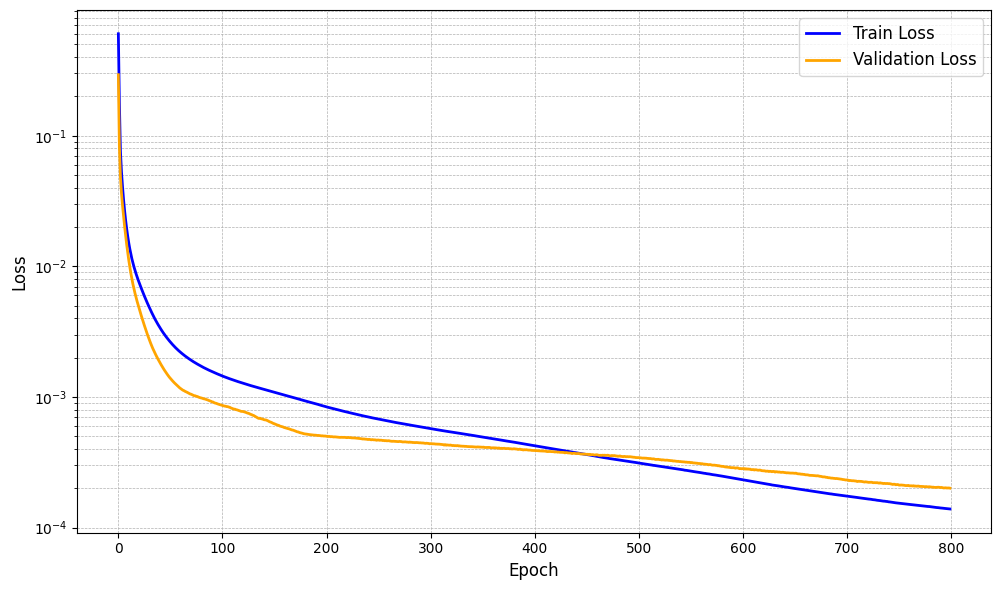


Figure saved as '[14 bus] Loss Curves.png'!

✅ Figure saved as high-quality PDF: '[14 bus] Loss Curves.pdf' (dpi=1000)
Last epoch: 800, Train loss: 0.0001387, Val loss: 0.0002002
Best epoch: 800, Best Train loss: 0.0001387, Best Val loss: 0.0002002


In [25]:


# Plot the training and validation loss
plt.figure(figsize=(10, 6))

#plt.title(f'Loss Curves for GNN Model Predicting V and δ on IEEE {n_bus}-Bus Dataset', fontsize=14)
plt.plot(train_loss_list, label="Train Loss", color='blue', linewidth=2)
plt.plot(val_loss_list, label="Validation Loss", color='orange', linewidth=2)
#plt.yscale('log')  # logarithmic scale
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend(loc='best', fontsize=12)
plt.tight_layout()
plt.yscale('log')  # logarithmic scale
plt.show()

# Save the figure with improved formatting
figure_filename = f"[{n_bus} bus] Loss Curves.png"
plt.savefig(figure_filename, dpi=300, bbox_inches='tight')
plt.close()
print(f"\nFigure saved as '{figure_filename}'!")

figure_filename = f"[{n_bus} bus] Loss Curves.pdf"
plt.savefig(figure_filename, format='pdf', dpi=1000, bbox_inches='tight')
plt.close()
print(f"\n✅ Figure saved as high-quality PDF: '{figure_filename}' (dpi=1000)")


# Print final and best losses
print(f"Last epoch: {epoch + 1}, Train loss: {train_loss:.7f}, Val loss: {val_loss:.7f}")
print(f"Best epoch: {best_epoch + 1}, Best Train loss: {best_train_loss:.7f}, Best Val loss: {best_val_loss:.7f}")

In [41]:
## hagamos una prediccion
import torch
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import pandas as pd

# Function to calculate regression metrics
def evaluate_regression_metrics(y_true, y_pred):
    # Denormalize the outputs
    y_true = denormalize_output(y_true, y_val_mean, y_val_std)
    y_pred = denormalize_output(y_pred, y_val_mean, y_val_std)

    # Convert to numpy arrays
    y_true = y_true.detach().cpu().numpy()
    y_pred = y_pred.detach().cpu().numpy()

    # Calculate metrics
    mse = mean_squared_error(y_true.reshape(-1, 2), y_pred.reshape(-1, 2))
    rmse = np.sqrt(mse)
    nrmse = rmse / np.std(y_true)
    mae = mean_absolute_error(y_true.reshape(-1, 2), y_pred.reshape(-1, 2))
    r2 = r2_score(y_true.reshape(-1, 2), y_pred.reshape(-1, 2))

    # MAPE with zero filtering (reshape done inside)
    y_t = y_true.reshape(-1, 2)
    y_p = y_pred.reshape(-1, 2)
    non_zero_mask = y_t != 0
    mape = np.mean(np.abs((y_t[non_zero_mask] - y_p[non_zero_mask]) / y_t[non_zero_mask])) * 100

    # Print metrics
    print(f"Mean Squared Error (MSE): {mse:.6f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.6f}")
    print(f"Normalized RMSE (NRMSE): {nrmse:.6f}")
    print(f"Mean Absolute Error (MAE): {mae:.6f}")
    print(f"R^2 Score: {r2:.6f}")
    print(f"Mean Absolute Percentage Error (MAPE): {mape:.6f}%")

    return mse, rmse, nrmse, mae, r2, mape


In [42]:
## probamos el modelo
# Evaluation after training
model.eval()
y_val_predictions = []

# Collect all predictions and ground truth for the validation set
with torch.no_grad():
    for batch in val_loader:
        # Forward pass for validation
        y_val_pred = model(batch)

        # Skip empty batches
        if y_val_pred.size(0) == 0:
            continue

        # Reshape predictions based on the actual size
        y_val_pred = y_val_pred.view(-1, n_bus, 2)
        y_val_predictions.append(y_val_pred)

# Stack predictions and targets with the shape [n_samples, n_bus, 2]
y_val_predictions = torch.cat(y_val_predictions, dim=0)
y_val_targets = torch.cat([batch.y.view(-1, n_bus, 2) for batch in val_loader], dim=0)

# Calculate and print regression metrics
mse, rmse, nrmse, mae, r2, mape = evaluate_regression_metrics(y_val_targets, y_val_predictions)

Mean Squared Error (MSE): 0.000200
Root Mean Squared Error (RMSE): 0.014148
Normalized RMSE (NRMSE): 0.001927
Mean Absolute Error (MAE): 0.007999
R^2 Score: 0.994379
Mean Absolute Percentage Error (MAPE): 0.128023%


Now, let´s go to predict with leaving ceteris paribus the model, with test data with variations.

In [ ]:
def read_variational_df(data):
    
    df = data
    df_filtrado = df.iloc[:, [0] + list(range(8, df.shape[1]))]
    df_filtrado = df_filtrado.loc[:, ~df_filtrado.columns.str.startswith('Z')]
    df_filtrado = np.array(df_filtrado)
    
    return df_filtrado
    

In [55]:

## leeremos el archivo


train = read_variational_df(train14)

val = read_variational_df(val14)

test = read_variational_df(test14)

# Split the dataset
train_percentage = 100
val_percentage = 100

train_dataset = slice_dataset(train, train_percentage)
val_dataset = slice_dataset(val, train_percentage)
test_dataset = slice_dataset(test, train_percentage)


n_bus = 14

# Prepare training and validation data
x_raw_train, y_raw_train = make_dataset(train_dataset, n_bus)
x_raw_val, y_raw_val = make_dataset(val_dataset, n_bus)
x_raw_test, y_raw_test = make_dataset(test_dataset, n_bus)

# Normalize the raw data
x_norm_train, y_norm_train, x_train_mean, y_train_mean, x_train_std, y_train_std = normalize_dataset(x_raw_train, y_raw_train)
x_norm_val, y_norm_val, x_val_mean, y_val_mean, x_val_std, y_val_std = normalize_dataset(x_raw_val, y_raw_val)
x_norm_test, y_norm_test, x_test_mean, y_test_mean, x_test_std, y_test_std = normalize_dataset(x_raw_test, y_raw_test)

# Prepare DataLoader for PyTorch Geometric
# Load the IEEE 14-bus test case using pandapower
net = nw.case14()

# Get the 'from_bus' and 'to_bus' for each line in the network
from_buses = net.line['from_bus'].values
to_buses = net.line['to_bus'].values

# Construct the edge index (bidirectional edges)
edge_index = torch.tensor([list(from_buses) + list(to_buses), list(to_buses) + list(from_buses)], dtype=torch.long)

print("Edge Index for IEEE 14-bus System:")
print(edge_index)

# Create Data objects for PyTorch Geometric
train_data_list = [Data(x=x, y=y, edge_index=edge_index) for x, y in zip(x_norm_train, y_norm_train)]
val_data_list = [Data(x=x, y=y, edge_index=edge_index) for x, y in zip(x_norm_val, y_norm_val)]
test_data_list = [Data(x=x, y=y, edge_index=edge_index) for x, y in zip(x_norm_test, y_norm_test)]

# Prepare DataLoaders
train_loader2 = DataLoader(train_data_list, batch_size=16)
val_loader2 = DataLoader(val_data_list, batch_size=16)
test_loader2 = DataLoader(test_data_list, batch_size=16)

print("Data preparation completed successfully.")


Edge Index for IEEE 14-bus System:
tensor([[ 0,  0,  1,  1,  1,  2,  3,  5,  5,  5,  8,  8,  9, 11, 12,  1,  4,  2,
          3,  4,  3,  4, 10, 11, 12,  9, 13, 10, 12, 13],
        [ 1,  4,  2,  3,  4,  3,  4, 10, 11, 12,  9, 13, 10, 12, 13,  0,  0,  1,
          1,  1,  2,  3,  5,  5,  5,  8,  8,  9, 11, 12]])
Data preparation completed successfully.


In [56]:
## probamos el modelo
# Evaluation after training
model.eval()
y_val_predictions = []

# Collect all predictions and ground truth for the validation set
with torch.no_grad():
    for batch in test_loader2:
        # Forward pass for validation
        y_val_pred = model(batch)

        # Skip empty batches
        if y_val_pred.size(0) == 0:
            continue

        # Reshape predictions based on the actual size
        y_val_pred = y_val_pred.view(-1, n_bus, 2)
        y_val_predictions.append(y_val_pred)

# Stack predictions and targets with the shape [n_samples, n_bus, 2]
y_val_predictions = torch.cat(y_val_predictions, dim=0)
y_val_targets = torch.cat([batch.y.view(-1, n_bus, 2) for batch in test_loader2], dim=0)

# Calculate and print regression metrics
mse, rmse, nrmse, mae, r2, mape = evaluate_regression_metrics(y_val_targets, y_val_predictions)


Mean Squared Error (MSE): 67.164177
Root Mean Squared Error (RMSE): 8.195375
Normalized RMSE (NRMSE): 0.717532
Mean Absolute Error (MAE): 4.289773
R^2 Score: 0.161548
Mean Absolute Percentage Error (MAPE): 28.603685%


In [58]:
# Initialize lists to store loss values
train_loss_list, val_loss_list = [], []

# Early stopping parameters
patience_count = 100
count = 0
best_epoch = 0
lossMin = float('inf')

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=20, verbose=True)

# Training loop
for epoch in range(800):  # Number of epochs
    model.train()
    train_loss = 0.0

    # Training phase
    for batch in train_loader2:
        optimizer.zero_grad()

        # Get the batch size
        batch_size = batch.num_graphs

        # Expand y_val_mean and y_val_std to match the batch size
        y_val_mean_expanded = y_val_mean.view(-1).repeat(batch_size)
        y_val_std_expanded = y_val_std.view(-1).repeat(batch_size)

        # Forward pass
        y_pred = model(batch)
        y_pred = y_pred.view(-1)  # Flatten predictions

        # Compute loss using the expanded mean and std
        loss = MSE(
            denormalize_output(y_pred, y_val_mean_expanded, y_val_std_expanded),
            denormalize_output(batch.y.view(-1), y_val_mean_expanded, y_val_std_expanded)
        )

        # Backpropagation
        loss.backward()
        optimizer.step()

        # Accumulate loss
        train_loss += loss.item() * batch.num_graphs

    # average training loss
    train_loss /= len(train_loader2.dataset)
    train_loss_list.append(train_loss)

    # Validation phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch in val_loader2:
            # Get the batch size for validation
            batch_size = batch.num_graphs

            # Expand y_val_mean and y_val_std to match the batch size
            y_val_mean_expanded = y_val_mean.view(-1).repeat(batch_size)
            y_val_std_expanded = y_val_std.view(-1).repeat(batch_size)

            # Forward pass for validation
            y_val_pred = model(batch)
            y_val_pred = y_val_pred.view(-1)

            # Compute validation loss using expanded mean and std
            loss = MSE(
                denormalize_output(y_val_pred, y_val_mean_expanded, y_val_std_expanded),
                denormalize_output(batch.y.view(-1), y_val_mean_expanded, y_val_std_expanded)
            )
            val_loss += loss.item() * batch.num_graphs

    # Compute average validation loss
    val_loss /= len(val_loader2.dataset)
    val_loss_list.append(val_loss)

    # Learning rate adjustment based on validation loss
    scheduler.step(val_loss)

    # Early stopping mechanism
    if val_loss < lossMin:
        lossMin = val_loss
        count = 0
        best_epoch = epoch
        best_train_loss = train_loss
        best_val_loss = val_loss

        # Save the best model weights
        model_filename = f"[{n_bus} bus] Best_GNN_GNN_NN_model_variations.pt"
        model.save_weights(model_filename)

    else:
        count += 1
        if count > patience_count:
            print(f"Early stopping at epoch {epoch} | Best epoch: {best_epoch}")
            print(f"Best train loss: {best_train_loss:.7f} | Best val loss: {best_val_loss:.7f}")
            break

    # Log progress every 10 epochs
    if epoch % 10 == 0:
        print(f"Epoch {epoch} | Train loss: {train_loss:.7f} | Val loss: {val_loss:.7f}")

print("Training complete.")
print(f"Best Epoch: {best_epoch} | Best Train Loss: {best_train_loss:.7f} | Best Val Loss: {best_val_loss:.7f}")


Epoch 0 | Train loss: 41.0391444 | Val loss: 40.6961696
Epoch 10 | Train loss: 39.9926791 | Val loss: 40.7581873
Epoch 20 | Train loss: 39.7106359 | Val loss: 40.8615158
Epoch 00023: reducing learning rate of group 0 to 2.5000e-05.
Epoch 30 | Train loss: 39.4467808 | Val loss: 40.9515246
Epoch 40 | Train loss: 39.2808217 | Val loss: 41.0302218
Epoch 00044: reducing learning rate of group 0 to 1.2500e-05.
Epoch 50 | Train loss: 39.1158033 | Val loss: 41.1043516
Epoch 60 | Train loss: 39.0273714 | Val loss: 41.1573892
Epoch 00065: reducing learning rate of group 0 to 6.2500e-06.
Epoch 70 | Train loss: 38.9334772 | Val loss: 41.2078213
Epoch 80 | Train loss: 38.8861692 | Val loss: 41.2390992
Epoch 00086: reducing learning rate of group 0 to 3.1250e-06.
Epoch 90 | Train loss: 38.8333991 | Val loss: 41.2654437
Epoch 100 | Train loss: 38.8091978 | Val loss: 41.2812949
Early stopping at epoch 102 | Best epoch: 1
Best train loss: 40.3266060 | Best val loss: 40.6797435
Training complete.
Best E

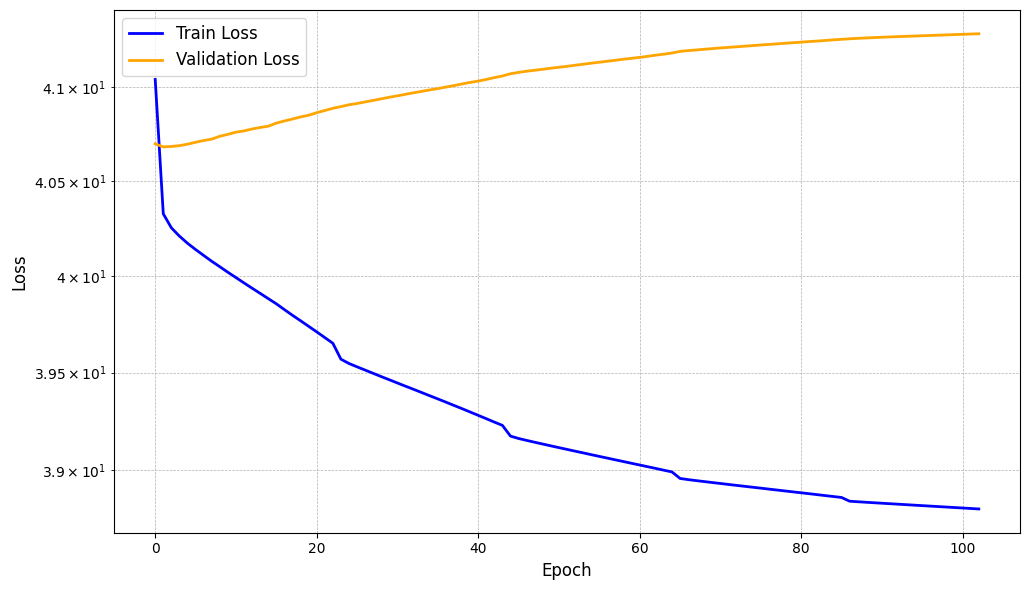


Figure saved as '[14 bus] Loss Curves.png'!
Last epoch: 103, Train loss: 38.8043730, Val loss: 41.2841968
Best epoch: 2, Best Train loss: 40.3266060, Best Val loss: 40.6797435


In [59]:


# Plot the training and validation loss
plt.figure(figsize=(10, 6))


plt.plot(train_loss_list, label="Train Loss", color='blue', linewidth=2)
plt.plot(val_loss_list, label="Validation Loss", color='orange', linewidth=2)
#plt.yscale('log')  # logarithmic scale
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend(loc='best', fontsize=12)
plt.tight_layout()
plt.yscale('log')  # logarithmic scale
plt.show()

# Save the figure with improved formatting
figure_filename = f"[{n_bus} bus] Loss Curves.png"
plt.savefig(figure_filename, dpi=300, bbox_inches='tight')
plt.close()
print(f"\nFigure saved as '{figure_filename}'!")



# Print final and best losses
print(f"Last epoch: {epoch + 1}, Train loss: {train_loss:.7f}, Val loss: {val_loss:.7f}")
print(f"Best epoch: {best_epoch + 1}, Best Train loss: {best_train_loss:.7f}, Best Val loss: {best_val_loss:.7f}")

In [60]:
## probamos el modelo
# Evaluation after training
model.eval()
y_val_predictions = []

# Collect all predictions and ground truth for the validation set
with torch.no_grad():
    for batch in test_loader2:
        # Forward pass for validation
        y_val_pred = model(batch)

        # Skip empty batches
        if y_val_pred.size(0) == 0:
            continue

        # Reshape predictions based on the actual size
        y_val_pred = y_val_pred.view(-1, n_bus, 2)
        y_val_predictions.append(y_val_pred)

# Stack predictions and targets with the shape [n_samples, n_bus, 2]
y_val_predictions = torch.cat(y_val_predictions, dim=0)
y_val_targets = torch.cat([batch.y.view(-1, n_bus, 2) for batch in test_loader2], dim=0)

# Calculate and print regression metrics
mse, rmse, nrmse, mae, r2, mape = evaluate_regression_metrics(y_val_targets, y_val_predictions)

Mean Squared Error (MSE): 40.792179
Root Mean Squared Error (RMSE): 6.386876
Normalized RMSE (NRMSE): 0.559192
Mean Absolute Error (MAE): 2.835985
R^2 Score: 0.399288
Mean Absolute Percentage Error (MAPE): 16.110992%


## 2)  Roll-out configurations (test case pandapower 14-bus)

In [ ]:
# =========================================================
# E2E CONSOLIDADO — PF-GNN Flat Adapter (SAGEConv + GELU)
# =========================================================
import ast, math, json, time
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.utils import coalesce
from torch_geometric.nn import SAGEConv
import pandapower.networks as nw

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -----------------------------
# CONFIG ÚNICO
# -----------------------------
CONFIG = {
    "model": {
        "feat_size1":        135,
        "feat_size2":        88,
        "hidden_size1":      256,
        "ff2_size":          176,
        "dropout":           6.528e-4,
        "use_batch_norm":    False,
        "adapter_rank_flat": 64,
        "alpha_max_flat":    4.0,
        "alpha_init_flat":   0.01,
    },
    "optim": {
        "lrs": {
            "lr_conv":     0.001403571678978223,
            "lr_head":     0.001403571678978223,
            "lr_adapters": 0.0023812053573770418,
            "lr_alpha":    0.0023812053573770418,
        },
        "wds": {
            "wd_backbone": 9.858488847584123e-05,
            "wd_adapters": 0.00018241658084530078,
        },
        "l1_alpha_flat": 1.1685799252106392e-05,
    },
    "train": {
        "batch_size": 128,   # fijo para todos
        "shuffle":    False, # sin shuffle en train/val/test
        "mape_eps":   1e-3
    }
}

# -----------------------------
# TOPOLOGÍA BASE
# -----------------------------
def load_base_topology(n_bus: int):
    if n_bus == 14:   return nw.case14()
    elif n_bus == 30: return nw.case30()
    elif n_bus == 118:return nw.case118()
    else: raise ValueError(f"n_bus={n_bus} no soportado. Usa 14, 30, 118.")

# -----------------------------
# UTILS DE DATOS
# -----------------------------
def find_col(df: pd.DataFrame, base: str) -> str:
    cands = [c for c in df.columns if c.startswith(base)]
    if not cands: raise KeyError(f"No se encontró columna que empiece por '{base}'")
    cands.sort(key=len)
    return cands[0]

def build_numeric_matrix(df: pd.DataFrame, n_bus: int) -> np.ndarray:
    cols=[]
    for i in range(n_bus):
        cols += [find_col(df, f"P_{i}"), find_col(df, f"Q_{i}"),
                 find_col(df, f"V_{i}"), find_col(df, f"d_{i}"), find_col(df, f"Z_{i}")]
    sub=df[cols].copy()
    for c in sub.columns: sub[c]=pd.to_numeric(sub[c], errors="coerce")
    return sub.fillna(0.0).to_numpy(dtype=np.float32)

def make_dataset2(dataset: np.ndarray, n_bus: int, features_per_bus: int = 5,
                  zero_tol: float = 1e-8, slack_index: int = 0):
    x_raw, y_raw = [], []
    for i in range(len(dataset)):
        x_s, y_s = [], []
        for n in range(n_bus):
            b = features_per_bus * n
            P,Q,V,d,Z = map(float, dataset[i, b:b+5])
            is_slack = 1 if n==slack_index else 0
            is_pv = 1 if (n!=slack_index and abs(Q)<=zero_tol) else 0
            is_pq = 1 if (n!=slack_index and not is_pv) else 0
            x_s.append([P,Q,is_slack,is_pv,is_pq,Z]); y_s.append([V,d])
        x_raw.append(x_s); y_raw.append(y_s)
    return torch.tensor(x_raw, dtype=torch.float32), torch.tensor(y_raw, dtype=torch.float32)

def compute_norm_stats_from_train(x_tr: torch.Tensor, y_tr: torch.Tensor):
    pq_mean = torch.mean(x_tr[:, :, 0:2], 0)
    pq_std  = torch.std(x_tr[:, :, 0:2], 0); pq_std[pq_std==0]=1
    y_mean  = torch.mean(y_tr, 0)
    y_std   = torch.std(y_tr, 0); y_std[y_std==0]=1
    return pq_mean, pq_std, y_mean, y_std

def apply_norm_with_stats(x: torch.Tensor, y: torch.Tensor,
                          pq_mean: torch.Tensor, pq_std: torch.Tensor,
                          y_mean: torch.Tensor, y_std: torch.Tensor):
    dev=x.device
    pq_mean=pq_mean.to(dev); pq_std=pq_std.to(dev)
    y_mean=y_mean.to(dev);   y_std=y_std.to(dev)
    x_n=x.clone(); x_n[:,:,0:2]=(x[:,:,0:2]-pq_mean)/pq_std
    y_n=(y-y_mean)/y_std
    return x_n, y_n

def to_edge_index_from_any(ei_raw, bidirectional: bool=True, device: str="cpu"):
    if isinstance(ei_raw, str):
        try: ei_raw=ast.literal_eval(ei_raw)
        except Exception: pass
    if isinstance(ei_raw,(list,tuple)) and len(ei_raw)==2 and isinstance(ei_raw[0],(list,tuple)):
        ei=torch.tensor(ei_raw, dtype=torch.long)
        if bidirectional: ei=torch.cat([ei, torch.stack([ei[1],ei[0]],0)], 1)
        return coalesce(ei, num_nodes=None).to(device)
    edges=[]
    if isinstance(ei_raw,(list,tuple)):
        for e in ei_raw:
            if isinstance(e,str) and '-' in e: u,v=map(int,e.split('-'))
            else: u,v=int(e[0]),int(e[1])
            edges.append((u,v))
            if bidirectional: edges.append((v,u))
    ei=(torch.tensor(edges, dtype=torch.long).t().contiguous()
        if edges else torch.zeros((2,0), dtype=torch.long))
    return coalesce(ei, num_nodes=None).to(device)

def undirected_edge_set(edge_index_tensor: torch.Tensor):
    u=edge_index_tensor[0].tolist(); v=edge_index_tensor[1].tolist()
    s=set()
    for a,b in zip(u,v):
        if a==b: continue
        s.add((a,b) if a<b else (b,a))
    return s

def build_mixed_datalist(df: pd.DataFrame, n_bus: int,
                         x_norm: torch.Tensor, y_norm: torch.Tensor,
                         base_undirected: set):
    edges_raw=df['Branch_Edge_Index'].tolist()
    lst=[]
    for x,y,ei_raw in zip(x_norm, y_norm, edges_raw):
        ei=to_edge_index_from_any(ei_raw, True, "cpu")
        removed=base_undirected - undirected_edge_set(ei)
        is_pert=torch.tensor(1 if len(removed)>0 else 0, dtype=torch.long)
        lst.append(Data(x=x, y=y, edge_index=ei, is_pert=is_pert))
    return lst

# -----------------------------
# MODELO
# -----------------------------
class FlatAdapter(nn.Module):
    def __init__(self, dim_flat: int, r: int=64, act: nn.Module=nn.GELU()):
        super().__init__()
        self.down = nn.Linear(dim_flat, r, bias=False)
        self.up   = nn.Linear(r, dim_flat, bias=False)
        self.act  = act
        nn.init.orthogonal_(self.down.weight)
        nn.init.kaiming_uniform_(self.up.weight, a=0.2)
    def forward(self, z: torch.Tensor) -> torch.Tensor:
        return self.up(self.act(self.down(z)))

class PF_GNN_FlatAdapter(nn.Module):
    def __init__(self, node_size: int=14, feat_in: int=6,
                 feat_size1: int=CONFIG["model"]["feat_size1"],
                 feat_size2: int=CONFIG["model"]["feat_size2"],
                 hidden_size1: int=CONFIG["model"]["hidden_size1"],
                 ff2_size: int=CONFIG["model"]["ff2_size"],
                 dropout: float=CONFIG["model"]["dropout"],
                 output_size: int|None=None,
                 use_batch_norm: bool=CONFIG["model"]["use_batch_norm"],
                 adapter_rank_flat: int=CONFIG["model"]["adapter_rank_flat"],
                 alpha_max_flat: float=CONFIG["model"]["alpha_max_flat"],
                 alpha_init_flat: float=CONFIG["model"]["alpha_init_flat"]):
        super().__init__()
        self.node_size=node_size
        self.feat_size2=feat_size2
        self.use_batch_norm=use_batch_norm

        self.conv1=SAGEConv(feat_in, feat_size1)
        self.conv2=SAGEConv(feat_size1, feat_size2)
        if use_batch_norm:
            self.bn1=nn.BatchNorm1d(feat_size1)
            self.bn2=nn.BatchNorm1d(feat_size2)

        if output_size is None: output_size=2*node_size
        self.lin1 = nn.Linear(node_size*feat_size2, hidden_size1)
        self.lin2a= nn.Linear(hidden_size1, ff2_size)
        self.lin2b= nn.Linear(ff2_size, output_size)

        self.act_gnn=nn.GELU(); self.act_fc=nn.GELU()
        self.dropout=nn.Dropout(dropout)

        dim_flat=node_size*feat_size2
        self.adapter_flat = FlatAdapter(dim_flat, r=adapter_rank_flat, act=nn.GELU())

        init_beta=math.log(alpha_init_flat/(alpha_max_flat-alpha_init_flat+1e-12))
        self.alpha_max_flat=float(alpha_max_flat)
        self.beta_flat=nn.Parameter(torch.tensor(float(init_beta)))

    def alpha_eff_flat(self) -> torch.Tensor:
        return self.alpha_max_flat*torch.sigmoid(self.beta_flat)

    def forward(self, data: Data) -> torch.Tensor:
        x,ei=data.x, data.edge_index
        x=self.act_gnn(self.conv1(x,ei))
        if self.use_batch_norm: x=self.bn1(x)
        x=self.act_gnn(self.conv2(x,ei))
        if self.use_batch_norm: x=self.bn2(x)

        B=data.num_graphs; N=self.node_size
        z=x.view(B, N*self.feat_size2)

        if hasattr(data,"is_pert"):
            gmask=data.is_pert.reshape(-1).bool().to(z.device)
            if gmask.any():
                idx=torch.where(gmask)[0]
                z_adj=z.clone()
                z_adj[idx]=z_adj[idx] + self.alpha_eff_flat()*self.adapter_flat(z[idx])
                z=z_adj

        z=self.act_fc(self.lin1(z));  z=self.dropout(z)
        z=self.act_fc(self.lin2a(z)); z=self.dropout(z)
        return self.lin2b(z)

# -----------------------------
# MÉTRICAS / EVAL (desnormalizado)
# -----------------------------
def _graph_mse_denorm(pred: torch.Tensor, y: torch.Tensor,
                      y_mean: torch.Tensor, y_std: torch.Tensor):
    pred_d=pred*y_std + y_mean
    y_d   =y   *y_std + y_mean
    mse_g =F.mse_loss(pred_d, y_d, reduction='none').mean(dim=(1,2))
    return mse_g, pred_d, y_d

@torch.no_grad()
def eval_loader_denorm_breakdown(loader, model, y_mean, y_std, n_bus: int):
    model.eval()
    tot_nom=tot_per=0.0; n_nom=n_per=0
    for batch in loader:
        batch=batch.to(device)
        out=model(batch); B=batch.num_graphs
        pred=out.view(B,n_bus,2); y=batch.y.view(B,n_bus,2)
        mse_g,_,_=_graph_mse_denorm(pred,y,y_mean,y_std)
        gmask=batch.is_pert.reshape(-1).bool()
        if (~gmask).any(): tot_nom+=mse_g[~gmask].sum().item(); n_nom+=int((~gmask).sum().item())
        if ( gmask).any(): tot_per+=mse_g[ gmask].sum().item(); n_per+=int(( gmask).sum().item())
    n_all=n_nom+n_per
    return dict(glb=(tot_nom+tot_per)/max(1,n_all),
                nom=tot_nom/max(1,n_nom),
                pert=tot_per/max(1,n_per))

@torch.no_grad()
def eval_loader_denorm_full(loader, model, y_mean, y_std, n_bus: int,
                            mape_eps: float=CONFIG["train"]["mape_eps"]):
    model.eval()
    preds,trues,masks=[],[],[]
    for batch in loader:
        batch=batch.to(device)
        out=model(batch); B=batch.num_graphs
        pred=out.view(B,n_bus,2); y=batch.y.view(B,n_bus,2)
        _,pd,yd=_graph_mse_denorm(pred,y,y_mean,y_std)
        preds.append(pd.cpu()); trues.append(yd.cpu()); masks.append(batch.is_pert.reshape(-1).cpu().bool())
    P=torch.cat(preds,0); T=torch.cat(trues,0); M=torch.cat(masks,0)
    def _metrics(T,P):
        flat_true=T.reshape(-1,2); flat_pred=P.reshape(-1,2)
        mse=torch.mean((flat_pred-flat_true)**2)
        rmse=torch.sqrt(mse); nrmse=rmse/(torch.std(flat_true)+1e-12)
        mae=torch.mean(torch.abs(flat_pred-flat_true))
        ss_res=torch.sum((flat_true-flat_pred)**2)
        ss_tot=torch.sum((flat_true-torch.mean(flat_true,dim=0))**2)
        r2=1.0-ss_res/torch.clamp(ss_tot,min=1e-12)
        denom=torch.clamp(torch.abs(flat_true),min=mape_eps)
        mape_all=torch.mean(torch.abs((flat_true-flat_pred)/denom))
        Vt,dt=flat_true[:,0],flat_true[:,1]; Vp,dp=flat_pred[:,0],flat_pred[:,1]
        mape_V=torch.mean(torch.abs((Vt-Vp)/torch.clamp(torch.abs(Vt),min=mape_eps)))
        mape_d=torch.mean(torch.abs((dt-dp)/torch.clamp(torch.abs(dt),min=mape_eps)))
        return dict(MSE=mse.item(),RMSE=rmse.item(),NRMSE=nrmse.item(),MAE=mae.item(),
                    R2=r2.item(),MAPE=mape_all.item(),MAPE_V=mape_V.item(),MAPE_d=mape_d.item())
    res_glb=_metrics(T,P)
    res_nom=_metrics(T[~M],P[~M]) if (~M).any() else None
    res_per=_metrics(T[M], P[M])  if ( M).any() else None
    return res_glb,res_nom,res_per

@torch.no_grad()
def per_node_mse_denorm(loader, model, y_mean, y_std, n_bus: int):
    model.eval()
    sum_sq_V=torch.zeros(n_bus,dtype=torch.float64,device="cpu")
    sum_sq_d=torch.zeros(n_bus,dtype=torch.float64,device="cpu")
    count=0
    for batch in loader:
        batch=batch.to(device)
        out=model(batch); B=batch.num_graphs
        pred=out.view(B,n_bus,2); y=batch.y.view(B,n_bus,2)
        pred_d=(pred*y_std+y_mean).detach().cpu().double()
        y_d   =(y   *y_std+y_mean).detach().cpu().double()
        err=pred_d-y_d
        sum_sq_V+=torch.sum(err[:,:,0]**2,0); sum_sq_d+=torch.sum(err[:,:,1]**2,0)
        count+=B
    mse_V=(sum_sq_V/max(1,count)).numpy(); mse_d=(sum_sq_d/max(1,count)).numpy()
    return mse_V,mse_d

# -----------------------------
# LOADERS
# -----------------------------
def make_loaders(train_df: pd.DataFrame, val_df: pd.DataFrame, test_df: pd.DataFrame, n_bus: int):
    # matrices
    train_arr=build_numeric_matrix(train_df.drop(columns=['Branch_Edge_Index']), n_bus)
    val_arr  =build_numeric_matrix(val_df.drop(columns=['Branch_Edge_Index']),   n_bus)
    test_arr =build_numeric_matrix(test_df.drop(columns=['Branch_Edge_Index']),  n_bus)
    # tensores
    xtr_raw,ytr_raw=make_dataset2(train_arr,n_bus)
    xva_raw,yva_raw=make_dataset2(val_arr,  n_bus)
    xte_raw,yte_raw=make_dataset2(test_arr, n_bus)
    # stats SOLO TRAIN
    pq_mean,pq_std,y_mean,y_std=compute_norm_stats_from_train(xtr_raw,ytr_raw)
    xtr_n,ytr_n=apply_norm_with_stats(xtr_raw,ytr_raw,pq_mean,pq_std,y_mean,y_std)
    xva_n,yva_n=apply_norm_with_stats(xva_raw,yva_raw,pq_mean,pq_std,y_mean,y_std)
    xte_n,yte_n=apply_norm_with_stats(xte_raw,yte_raw,pq_mean,pq_std,y_mean,y_std)
    # topología y listas
    net=load_base_topology(n_bus)
    ei_nom=torch.tensor([
        list(net.line['from_bus'].values)+list(net.line['to_bus'].values),
        list(net.line['to_bus'].values)  +list(net.line['from_bus'].values)
    ], dtype=torch.long)
    base_und=undirected_edge_set(ei_nom)
    tr_list=build_mixed_datalist(train_df, n_bus, xtr_n, ytr_n, base_und)
    va_list=build_mixed_datalist(val_df,   n_bus, xva_n, yva_n, base_und)
    te_list=build_mixed_datalist(test_df,  n_bus, xte_n, yte_n, base_und)
    # loaders (batch fijo + shuffle=False)
    bs=CONFIG["train"]["batch_size"]; sh=CONFIG["train"]["shuffle"]
    tr_loader=DataLoader(tr_list, batch_size=bs, shuffle=sh)
    va_loader=DataLoader(va_list, batch_size=bs, shuffle=sh)
    te_loader=DataLoader(te_list, batch_size=bs, shuffle=sh)
    # stats
    stats_dev=dict(pq_mean=pq_mean.to(device), pq_std=pq_std.to(device),
                   y_mean=y_mean.to(device),   y_std=y_std.to(device))
    stats_cpu=dict(pq_mean=pq_mean.cpu(), pq_std=pq_std.cpu(),
                   y_mean=y_mean.cpu(),   y_std=y_std.cpu())
    return tr_loader, va_loader, te_loader, stats_dev, stats_cpu

# -----------------------------
# TRAIN (loss real) + SAVE
# -----------------------------
def count_params(model: nn.Module):
    counts=dict(conv=0,head=0,adapter=0,beta=0,other=0)
    for name,p in model.named_parameters():
        if not p.requires_grad: continue
        n=p.numel()
        if   name.startswith("conv"): counts["conv"]+=n
        elif name.startswith(("lin1","lin2a","lin2b")): counts["head"]+=n
        elif name.startswith("adapter_flat"): counts["adapter"]+=n
        elif name=="beta_flat": counts["beta"]+=n
        else: counts["other"]+=n
    counts["total"]=sum(counts.values()); return counts

def train_epoch_realspace(model, loader, optimizer, y_mean, y_std, n_bus: int):
    model.train()
    tot_nom=tot_per=0.0; n_nom=n_per=0
    for batch in loader:
        batch=batch.to(device)
        optimizer.zero_grad(set_to_none=True)
        out=model(batch); B=batch.num_graphs
        pred=out.view(B,n_bus,2); y=batch.y.view(B,n_bus,2)
        mse_g,_,_=_graph_mse_denorm(pred,y,y_mean,y_std)
        loss = mse_g.mean() + CONFIG["optim"]["l1_alpha_flat"]*torch.abs(model.alpha_eff_flat())
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        gmask=batch.is_pert.reshape(-1).bool()
        if (~gmask).any(): tot_nom+=mse_g[~gmask].sum().item(); n_nom+=int((~gmask).sum().item())
        if ( gmask).any(): tot_per+=mse_g[ gmask].sum().item(); n_per+=int(( gmask).sum().item())
    n_all=n_nom+n_per
    return dict(glb=(tot_nom+tot_per)/max(1,n_all),
                nom=tot_nom/max(1,n_nom),
                pert=tot_per/max(1,n_per))

def train_fit_and_save(train_df: pd.DataFrame, val_df: pd.DataFrame,
                       n_bus: int, save_path: str, epochs: int):
    # loaders + stats (val_df como "test" placeholder para construir stats coherentes)
    train_loader, val_loader, _, stats_dev, stats_cpu = make_loaders(train_df, val_df, val_df, n_bus)
    y_mean_dev, y_std_dev = stats_dev["y_mean"], stats_dev["y_std"]

    model = PF_GNN_FlatAdapter(node_size=n_bus).to(device)

    # optimizer con param groups
    lrs = CONFIG["optim"]["lrs"]; wds = CONFIG["optim"]["wds"]
    conv_params=[p for n,p in model.named_parameters() if n.startswith("conv")]
    head_params=list(model.lin1.parameters())+list(model.lin2a.parameters())+list(model.lin2b.parameters())
    adap_params=list(model.adapter_flat.parameters())
    beta_params=[model.beta_flat]
    params=[]
    if conv_params: params += [{"params":conv_params,"lr":lrs["lr_conv"],"weight_decay":wds["wd_backbone"]}]
    if head_params: params += [{"params":head_params,"lr":lrs["lr_head"],"weight_decay":wds["wd_backbone"]}]
    params += [{"params":adap_params,"lr":lrs["lr_adapters"],"weight_decay":wds["wd_adapters"]}]
    params += [{"params":beta_params,"lr":lrs["lr_alpha"],"weight_decay":0.0}]
    optim = torch.optim.AdamW(params)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, mode="min", patience=20, factor=0.5)

    pcounts=count_params(model)
    print(f"[PARAMS] total={pcounts['total']:,} | conv={pcounts['conv']:,} | head={pcounts['head']:,} | "
          f"adapter={pcounts['adapter']:,} | beta={pcounts['beta']:,} | other={pcounts['other']:,}")

    history={"train":{"glb":[], "nom":[], "pert":[]},
             "val"  :{"glb":[], "nom":[], "pert":[]}}
    best=float("inf"); best_state=None
    t0=time.perf_counter()

    for ep in range(1, epochs+1):
        tr = train_epoch_realspace(model, train_loader, optim, y_mean_dev, y_std_dev, n_bus)
        va = eval_loader_denorm_breakdown(val_loader, model, y_mean_dev, y_std_dev, n_bus)
        scheduler.step(va["glb"])
        for k in tr: history["train"][k].append(tr[k])
        for k in va: history["val"][k].append(va[k])
        with torch.no_grad(): a=float(abs(model.alpha_eff_flat().detach().item()))
        if ep==1 or ep%5==0:
            print(f"[{ep:03d}] Train={tr} || Val={va} || alpha={a:.3e}")
        if va["glb"] < best:
            best = va["glb"]
            best_state={k:v.detach().cpu().clone() for k,v in model.state_dict().items()}

    dur=time.perf_counter()-t0
    if best_state is not None: model.load_state_dict(best_state)

    bundle=dict(
        model_name="PF_GNN_FlatAdapter",
        state_dict=model.state_dict(),
        hparams=dict(node_size=n_bus, feat_in=6, **CONFIG["model"]),
        optim=CONFIG["optim"],
        stats=dict(
            pq_mean=stats_cpu["pq_mean"].numpy(), pq_std=stats_cpu["pq_std"].numpy(),
            y_mean=stats_cpu["y_mean"].numpy(),  y_std=stats_cpu["y_std"].numpy()
        ),
        history=history,
        train_time_sec=float(dur),
        param_counts=pcounts
    )
    torch.save(bundle, save_path)
    print(f"[DONE] Mejor Val(glb)={best:.6f} | bundle={save_path} | tiempo={dur:.1f}s")
    with open(save_path.replace(".pt","_history.json"),"w") as f: json.dump(history,f)
    return model, history

# -----------------------------
# TEST
# -----------------------------
@torch.no_grad()
def evaluate_bundle_on_test(bundle_path: str, train_df: pd.DataFrame, test_df: pd.DataFrame, n_bus: int | None = None):
    bundle=torch.load(bundle_path, map_location="cpu", weights_only=False)
    h=bundle["hparams"]; stats=bundle["stats"]
    n_eff = int(h["node_size"]) if n_bus is None else int(n_bus)

    model = PF_GNN_FlatAdapter(node_size=n_eff).to(device)
    model.load_state_dict(bundle["state_dict"]); model.eval()

    pq_mean=torch.tensor(stats["pq_mean"],dtype=torch.float32)
    pq_std =torch.tensor(stats["pq_std"], dtype=torch.float32)
    y_mean=torch.tensor(stats["y_mean"],dtype=torch.float32)
    y_std =torch.tensor(stats["y_std"], dtype=torch.float32)

    test_arr=build_numeric_matrix(test_df.drop(columns=['Branch_Edge_Index']), n_eff)
    xte_raw,yte_raw=make_dataset2(test_arr, n_eff)
    xte_n,yte_n=apply_norm_with_stats(xte_raw,yte_raw,pq_mean,pq_std,y_mean,y_std)

    net=load_base_topology(n_eff)
    ei_nom=torch.tensor([
        list(net.line['from_bus'].values)+list(net.line['to_bus'].values),
        list(net.line['to_bus'].values)  +list(net.line['from_bus'].values)
    ], dtype=torch.long)
    base_und=undirected_edge_set(ei_nom)
    te_list=build_mixed_datalist(test_df, n_eff, xte_n, yte_n, base_und)

    bs=CONFIG["train"]["batch_size"]; sh=CONFIG["train"]["shuffle"]
    te_loader=DataLoader(te_list, batch_size=bs, shuffle=sh)

    res_glb,res_nom,res_per=eval_loader_denorm_full(te_loader, model, y_mean.to(device), y_std.to(device), n_eff)
    mse_V_nodes,mse_d_nodes=per_node_mse_denorm(te_loader, model, y_mean.to(device), y_std.to(device), n_eff)

    def fmt(tag,m):
        if m is None: return f"{tag}: N/A"
        return (f"{tag}: MSE={m['MSE']:.6f}, RMSE={m['RMSE']:.6f}, NRMSE={m['NRMSE']:.6f}, "
                f"MAE={m['MAE']:.6f}, R2={m['R2']:.6f}, MAPE={m['MAPE']:.6f} "
                f"(V={m['MAPE_V']:.6f}, d={m['MAPE_d']:.6f})")
    print("== TEST RESULTS ==")
    print(fmt("GLOBAL  ", res_glb))
    print(fmt("NOMINAL ", res_nom))
    print(fmt("PERTURB ", res_per))
    print("== TEST per-node MSE (real) ==")
    for i in range(n_eff):
        print(f"Bus {i:>3}: MSE_V={mse_V_nodes[i]:.6e} | MSE_d={mse_d_nodes[i]:.6e}")

    return dict(
        GLOBAL=res_glb, NOMINAL=res_nom, PERTURB=res_per,
        MSE_PER_NODE={"V":mse_V_nodes.tolist(),"d":mse_d_nodes.tolist()},
        TRAIN_INFO=dict(train_time_sec=float(bundle.get("train_time_sec", float("nan"))),
                        param_counts=bundle.get("param_counts", {}))
    )

# -----------------------------
# ORQUESTADOR MULTI-RED
# -----------------------------
def validate_columns_for_network(df: pd.DataFrame, n_bus: int):
    req=["P_","Q_","V_","d_","Z_"]
    for i in range(n_bus):
        for pref in req: _=find_col(df, f"{pref}{i}")
    if 'Branch_Edge_Index' not in df.columns: raise KeyError("Falta columna 'Branch_Edge_Index'.")

def run_all_networks(datasets_by_nbus: dict, base_save_dir: str = ".",
                     tag: str = "pfgnn_flat_adapter", epochs: int = 500):
    import os
    os.makedirs(base_save_dir, exist_ok=True)
    out={}
    for n_bus, splits in datasets_by_nbus.items():
        train_df=splits["train"]; val_df=splits["val"]; test_df=splits["test"]
        validate_columns_for_network(train_df, n_bus)
        validate_columns_for_network(val_df,   n_bus)
        validate_columns_for_network(test_df,  n_bus)
        save_path=os.path.join(base_save_dir, f"{tag}_bundle_{n_bus}.pt")
        print(f"\n=== Red {n_bus} buses (epochs={epochs}, batch={CONFIG['train']['batch_size']}, shuffle={CONFIG['train']['shuffle']}) ===")
        model, history = train_fit_and_save(train_df, val_df, n_bus=n_bus, save_path=save_path, epochs=epochs)
        results = evaluate_bundle_on_test(save_path, train_df, test_df, n_bus=n_bus)
        out[n_bus]=dict(bundle=save_path, history=history, results=results)
    return out


In [ ]:
# DATASETS debe ser {14:{train,val,test}, 30:{...}, 118:{...}}
out = run_all_networks(DATASETS, base_save_dir="./bundles", tag="pfgnn_all", epochs=500)




=== Red 14 buses (epochs=500, batch=128, shuffle=False) ===
[PARAMS] total=549,136 | conv=25,603 | head=365,836 | adapter=157,696 | beta=1 | other=0
[001] Train={'glb': 9.205216933996905, 'nom': 1.2307109100823632, 'pert': 17.173649457512425} || Val={'glb': 1.7152633958922492, 'nom': 0.10257157249981454, 'pert': 3.2967235114372953} || alpha=1.013e-02
[005] Train={'glb': 0.1502052041281547, 'nom': 0.020001855656851038, 'pert': 0.2803093878252989} || Val={'glb': 0.16974311187366645, 'nom': 0.011508597315187085, 'pert': 0.3249132256220344} || alpha=1.008e-02
[010] Train={'glb': 0.08911443115593422, 'nom': 0.013222686893153346, 'pert': 0.16494837515651953} || Val={'glb': 0.1297769467499521, 'nom': 0.017744637932126783, 'pert': 0.23963961578433363} || alpha=9.875e-03
[015] Train={'glb': 0.06858368164371877, 'nom': 0.010938606260446605, 'pert': 0.12618485369463506} || Val={'glb': 0.11333326573338774, 'nom': 0.004063693431993576, 'pert': 0.22048670195148024} || alpha=9.502e-03
[020] Train={'

The supplied network uses an outdated geodata format. Please update your geodata by
running `pandapower.plotting.geo.convert_geodata_to_geojson(net)`
The supplied network uses an outdated geodata format. Please update your geodata by
running `pandapower.plotting.geo.convert_geodata_to_geojson(net)`


✅ Figure saved as 'Per-Bus_RMSE_Topology.pdf' (vector, 1000 dpi)


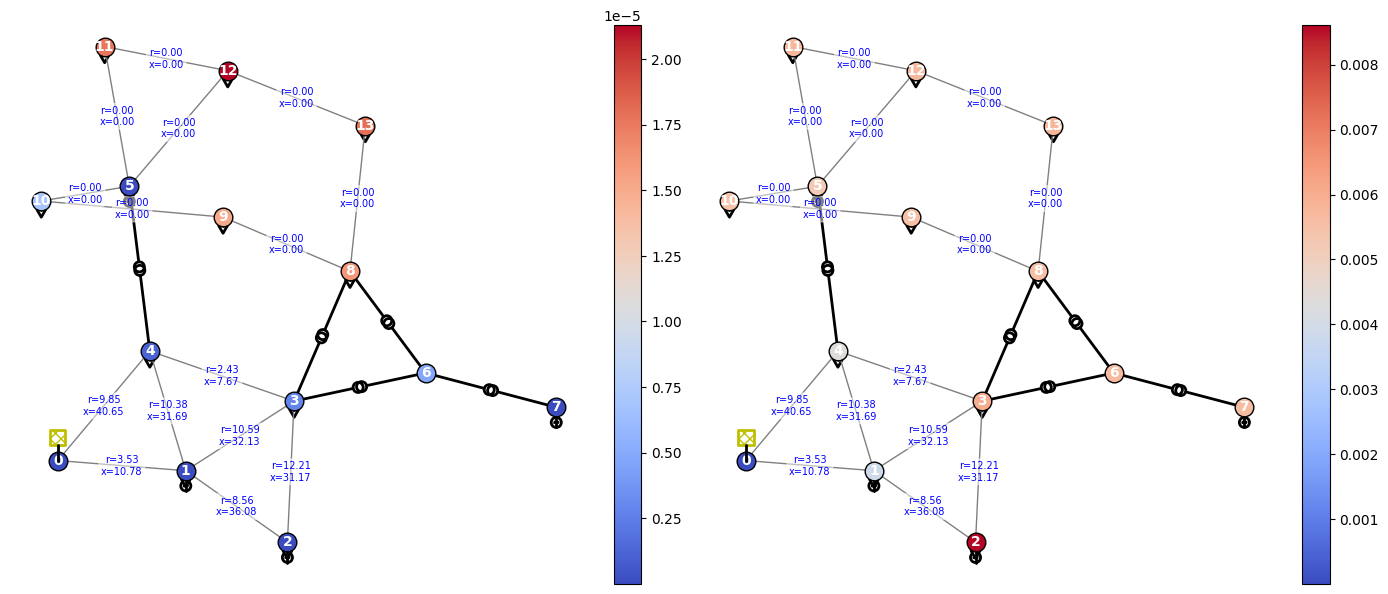

In [84]:
# This cell generates the requested two-panel topology-based visualization.
# It first tries to use pandapower (simple_plot + geodata). If pandapower is not
# available in this environment, it falls back to a NetworkX spring layout while
# keeping the same visual semantics (node color encodes per-bus RMSE).

import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# ----------------------------
# 1) Per-bus MSE (provided)
# ----------------------------
# MSE_V and MSE_d values per bus (0–13)
mse_v = np.array([
    6.579813e-11, 2.350665e-11, 2.545364e-10, 2.765029e-06,
    1.241624e-06, 1.266888e-09, 4.668494e-06, 3.509705e-12,
    1.612672e-05, 1.511499e-05, 6.958440e-06, 1.766060e-05,
    2.129355e-05, 1.790892e-05
])

mse_d = np.array([
    9.020491e-12, 3.861268e-03, 8.611748e-03, 6.040941e-03,
    4.396606e-03, 5.201215e-03, 5.657010e-03, 5.589521e-03,
    5.537910e-03, 5.565878e-03, 5.429457e-03, 5.764759e-03,
    5.701418e-03, 5.805937e-03
])

#rmse_v = np.sqrt(mse_v)
#rmse_d = np.sqrt(mse_d)

rmse_v = mse_v
rmse_d = mse_d

NBUS = len(rmse_v)

# -----------------------------------------
# 2) Try pandapower-based network plotting
# -----------------------------------------
use_pandapower = True
try:
    import pandapower as pp
    import pandapower.plotting as pplot
    from pandapower.plotting.geo import convert_geodata_to_geojson
    import pandas as pd

    # Load IEEE 14 and build geodata
    net = pp.networks.case14()
    convert_geodata_to_geojson(net)
    net.bus["geo_parsed"] = net.bus["geo"].apply(json.loads)
    net.bus["x"] = net.bus["geo_parsed"].apply(lambda g: g["coordinates"][0])
    net.bus["y"] = net.bus["geo_parsed"].apply(lambda g: g["coordinates"][1])
    net.bus_geodata = pd.DataFrame({"x": net.bus["x"], "y": net.bus["y"]})
except Exception as e:
    use_pandapower = False
    pp_error = str(e)

# -----------------------------------------
# 3) Plot
# -----------------------------------------
# -----------------------------------------
# 3) Plot
# -----------------------------------------
if use_pandapower:
    datasets = [
        (rmse_v, ""),
        (rmse_d, "")
    ]

    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    for ax, (data, label_data) in zip(axes, datasets):
        pplot.simple_plot(
            net,
            bus_size=0,
            bus_color="white",
            plot_line_switches=True,
            show_plot=False,
            plot_loads=True,
            plot_gens=True,
            ax=ax
        )
        ax.set_aspect("equal")
        ax.axis("off")
        ax.set_title(label_data)

        # Annotate line impedances
        for _, ln in net.line.iterrows():
            f, t = ln["from_bus"], ln["to_bus"]
            x0, y0 = net.bus_geodata.loc[f, ["x", "y"]]
            x1, y1 = net.bus_geodata.loc[t, ["x", "y"]]
            xm, ym = (x0 + x1) / 2, (y0 + y1) / 2
            r = ln["r_ohm_per_km"] * ln["length_km"]
            x = ln["x_ohm_per_km"] * ln["length_km"]
            ax.annotate(f"r={r:.2f}\nx={x:.2f}",
                        (xm, ym),
                        ha="center", va="center",
                        color="blue", fontsize=7,
                        bbox=dict(facecolor="white", alpha=0.5,
                                  edgecolor="white", boxstyle="round,pad=0.2"))

        # Color by RMSE
        norm = mcolors.Normalize(vmin=data.min(), vmax=data.max())
        cmap = plt.cm.coolwarm
        for i, (x, y) in net.bus_geodata[["x", "y"]].iterrows():
            ax.scatter(x, y,
                       s=180,
                       c=[cmap(norm(data[i]))],
                       edgecolors="k",
                       zorder=5)
            ax.text(x, y, str(i),
                    ha="center", va="center",
                    color="white", weight="bold",
                    zorder=6)

        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        cbar = plt.colorbar(sm, ax=ax, fraction=0.046, pad=0.04)
        cbar.set_label(label_data)

    plt.tight_layout()

    # ✅ Save here before showing
    fig.savefig("Per-Bus_RMSE_Topology.pdf", format='pdf', dpi=1000, bbox_inches='tight')
    print("✅ Figure saved as 'Per-Bus_RMSE_Topology.pdf' (vector, 1000 dpi)")

    plt.show()
    plt.close(fig)

else:
    import networkx as nx

    G = nx.Graph()
    G.add_nodes_from(range(NBUS))
    approx_edges = [
        (0,1),(1,2),(2,3),(3,4),(4,5),(5,6),(6,7),
        (7,8),(8,9),(9,10),(10,11),(11,12),(12,13),
        (1,5),(2,4),(3,5),(6,8),(7,9)
    ]
    for e in approx_edges:
        if e[0] < NBUS and e[1] < NBUS:
            G.add_edge(*e)

    pos = nx.circular_layout(G)
    datasets = [
        (rmse_v, ""),
        (rmse_d, "")
    ]

    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    for ax, (data, label) in zip(axes, datasets):
        ax.set_title(label)
        ax.axis("off")
        norm = mcolors.Normalize(vmin=data.min(), vmax=data.max())
        cmap = plt.cm.coolwarm

        # Edges
        for (u, v) in G.edges():
            x0, y0 = pos[u]
            x1, y1 = pos[v]
            ax.plot([x0, x1], [y0, y1], linewidth=1, alpha=0.5, zorder=1)

        # Nodes
        for i in G.nodes():
            x, y = pos[i]
            ax.scatter(x, y, s=180, c=[cmap(norm(data[i]))], edgecolors="k", zorder=2)
            ax.text(x, y, str(i), ha="center", va="center", color="white", weight="bold", zorder=3)

        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        cbar = plt.colorbar(sm, ax=ax, fraction=0.046, pad=0.04)
        cbar.set_label(label)

    plt.tight_layout()

    # ✅ Save before showing
    fig.savefig("Per-Bus_RMSE_Topology.pdf", format='pdf', dpi=1000, bbox_inches='tight')
    print("✅ Figure saved as 'Per-Bus_RMSE_Topology.pdf' (vector, 1000 dpi)")

    plt.show()
    plt.close(fig)

In [71]:
path2 = r'C:\Users\Usuario\OneDrive - Universidad Adolfo Ibanez\Desktop\GNN\PaperGNNPFFlatAdapter\bundles\\'

In [72]:
bundle = torch.load(path2+"pfgnn_all_bundle_14.pt", map_location="cpu")
h = bundle["hparams"]

# recreas el modelo
model = PF_GNN_FlatAdapter(
    node_size=h["node_size"], feat_in=h["feat_in"],
    feat_size1=h["feat_size1"], feat_size2=h["feat_size2"],
    hidden_size1=h["hidden_size1"], dropout=h["dropout"],
    use_batch_norm=h["use_batch_norm"],
    adapter_rank_flat=h["adapter_rank_flat"],
    alpha_max_flat=h["alpha_max_flat"], alpha_init_flat=h["alpha_init_flat"]
)
model.load_state_dict(bundle["state_dict"])

# cuentas parámetros entrenables
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Número de parámetros = {num_params:,}")

Número de parámetros = 549,136


In [73]:
bundle = torch.load(path2+"pfgnn_all_bundle_30.pt", map_location="cpu")
h = bundle["hparams"]

# recreas el modelo
model = PF_GNN_FlatAdapter(
    node_size=h["node_size"], feat_in=h["feat_in"],
    feat_size1=h["feat_size1"], feat_size2=h["feat_size2"],
    hidden_size1=h["hidden_size1"], dropout=h["dropout"],
    use_batch_norm=h["use_batch_norm"],
    adapter_rank_flat=h["adapter_rank_flat"],
    alpha_max_flat=h["alpha_max_flat"], alpha_init_flat=h["alpha_init_flat"]
)
model.load_state_dict(bundle["state_dict"])

# cuentas parámetros entrenables
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Número de parámetros = {num_params:,}")


Número de parámetros = 1,095,472


In [75]:
bundle = torch.load(path2+"pfgnn_all_bundle_118.pt", map_location="cpu")
h = bundle["hparams"]

# recreas el modelo
model = PF_GNN_FlatAdapter(
    node_size=h["node_size"], feat_in=h["feat_in"],
    feat_size1=h["feat_size1"], feat_size2=h["feat_size2"],
    hidden_size1=h["hidden_size1"], dropout=h["dropout"],
    use_batch_norm=h["use_batch_norm"],
    adapter_rank_flat=h["adapter_rank_flat"],
    alpha_max_flat=h["alpha_max_flat"], alpha_init_flat=h["alpha_init_flat"]
)
model.load_state_dict(bundle["state_dict"])

# cuentas parámetros entrenables
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Número de parámetros = {num_params:,}")

Número de parámetros = 4,100,320


In [52]:
path2 = r'C:\Users\Usuario\OneDrive - Universidad Adolfo Ibanez\Desktop\Doctorado\last_version\bundles\\'

✅ Figure saved as '[14-Bus] Loss_Curves.pdf' (vector, 1000 dpi)


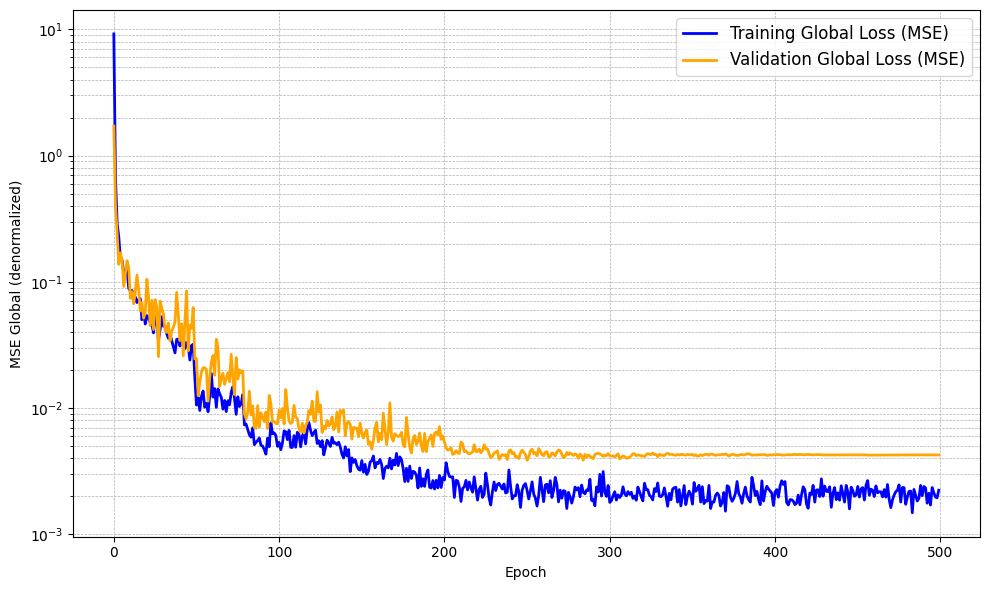

In [85]:
import json
import matplotlib.pyplot as plt

with open(path2 + "pfgnn_all_bundle_14_history.json") as f:
    history = json.load(f)

# Crear figura
fig = plt.figure(figsize=(10, 6))
n_bus = 14

# Curvas de pérdida
plt.plot(history["train"]["glb"], label="Training Global Loss (MSE)", color="blue", linewidth=2)
plt.plot(history["val"]["glb"], label="Validation Global Loss (MSE)", color="orange", linewidth=2)

plt.xlabel("Epoch")
plt.ylabel("MSE Global (denormalized)")
plt.yscale('log')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend(loc='best', fontsize=12)
plt.tight_layout()

# Guardar en PDF vectorial de alta calidad
figure_filename = f"[{n_bus}-Bus] Loss_Curves.pdf"
fig.savefig(figure_filename, format='pdf', dpi=1000, bbox_inches='tight')

print(f"✅ Figure saved as '{figure_filename}' (vector, 1000 dpi)")

plt.show()
plt.close(fig)


✅ Figure saved as '[30-Bus] Loss_Curves.pdf' (vector, 1000 dpi)


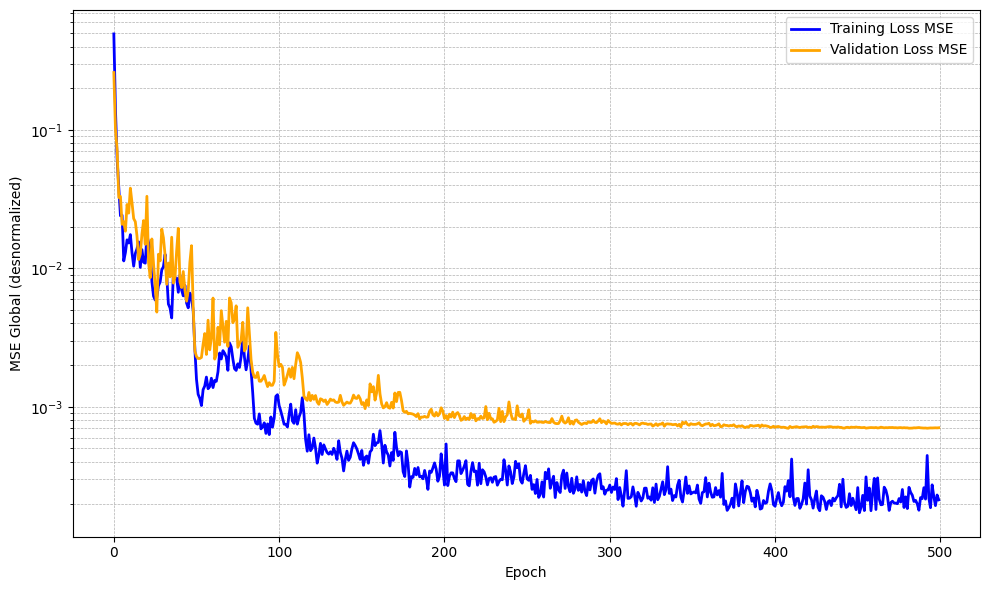

In [88]:
import json
import matplotlib.pyplot as plt

with open(path2+"pfgnn_all_bundle_30_history.json") as f:
    history = json.load(f)

# Plot the training and validation loss
plt.figure(figsize=(10, 6))

n_bus=30
#plt.title(f'Loss Curves Global for GNN Model V and δ on test case {n_bus}-Bus Dataset', fontsize=12)
plt.plot(history["train"]["glb"], label="Training Loss MSE", color="blue", linewidth=2)
plt.plot(history["val"]["glb"],   label="Validation Loss MSE", color="orange", linewidth=2)
plt.xlabel("Epoch")
plt.ylabel("MSE Global (desnormalized)")
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend(loc='best', fontsize=12)
plt.yscale('log')
plt.legend()

plt.tight_layout()

# Guardar en PDF vectorial de alta calidad
figure_filename = f"[{n_bus}-Bus] Loss_Curves.pdf"
fig.savefig(figure_filename, format='pdf', dpi=1000, bbox_inches='tight')

print(f"✅ Figure saved as '{figure_filename}' (vector, 1000 dpi)")
plt.show()
plt.close(fig)


✅ Figure saved as '[118-Bus] Loss_Curves.pdf' (vector, 1000 dpi)


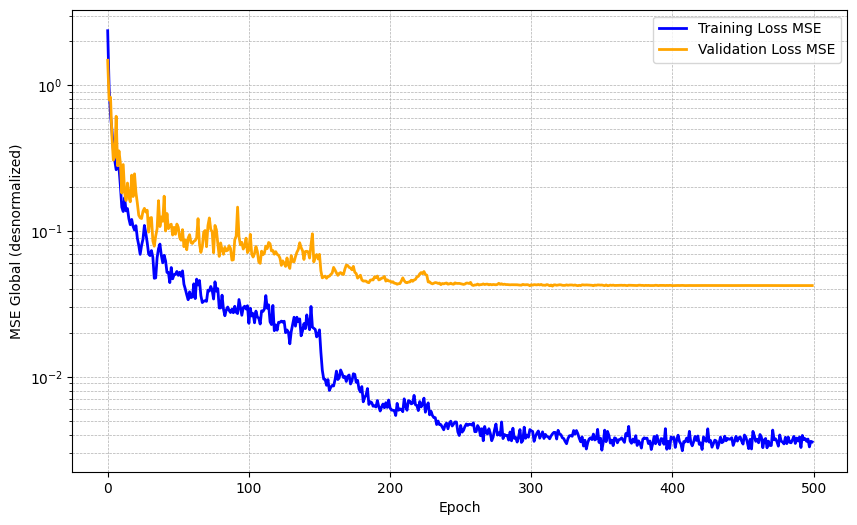

In [92]:
import json
import matplotlib.pyplot as plt

with open(path2+"pfgnn_all_bundle_118_history.json") as f:
    history = json.load(f)

# Plot the training and validation loss
plt.figure(figsize=(10, 6))

n_bus=118
#plt.title(f'Loss Curves Global for GNN Model V and δ on test case {n_bus}-Bus Dataset', fontsize=12)
plt.plot(history["train"]["glb"], label="Training Loss MSE", color="blue", linewidth=2)
plt.plot(history["val"]["glb"],   label="Validation Loss MSE", color="orange", linewidth=2)
plt.xlabel("Epoch")
plt.ylabel("MSE Global (desnormalized)")
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend(loc='best', fontsize=12)
plt.yscale('log')
plt.legend()

# Guardar en PDF vectorial de alta calidad
figure_filename = f"[{n_bus}-Bus] Loss_Curves.pdf"
fig.savefig(figure_filename, format='pdf', dpi=1000, bbox_inches='tight')

print(f"✅ Figure saved as '{figure_filename}' (vector, 1000 dpi)")

plt.show()
plt.close(fig)

In [ ]:
import pandapower.networks as nw
import networkx as nx
import pandas as pd

nets = {
    "14 Buses": nw.case14(),
    "30 Buses": nw.case30(),
    "118 Buses": nw.case118()
}

results = []

for name, net in nets.items():
    G = nx.Graph()
    G.add_nodes_from(net.bus.index)

    for _, line in net.line.iterrows():
        G.add_edge(line["from_bus"], line["to_bus"])
    for _, trafo in net.trafo.iterrows():
        G.add_edge(trafo["hv_bus"], trafo["lv_bus"])

    avg_deg = sum(dict(G.degree()).values()) / len(G.nodes)
    results.append([name, len(G.nodes), len(G.edges), avg_deg])

df_avg_deg = pd.DataFrame(results, columns=["Case", "Nodes", "Edges", "Average Degree"])
print(df_avg_deg)


        Case  Nodes  Edges  Average Degree
0   14 Buses     14     20        2.857143
1   30 Buses     30     41        2.733333
2   57 Buses     57     78        2.736842
3  118 Buses    118    179        3.033898
